## 这里采用的是requests结合ogr等等来读取json并转化为shp

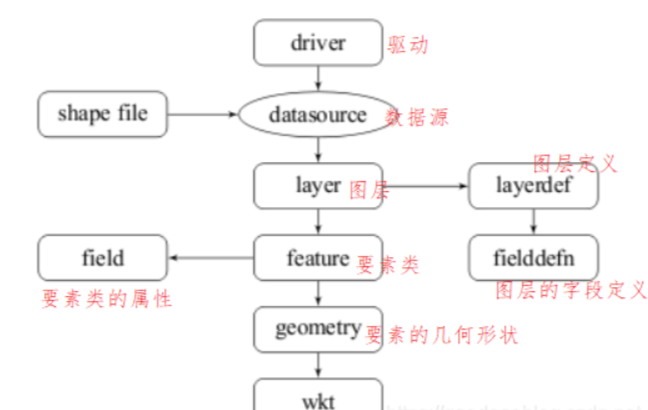

In [2]:
from osgeo import ogr, osr, gdal
import requests
import json

# 设置Shapefile的编码为UTF-8，这有助于确保中文或其他非ASCII字符能够正确保存和显示。
gdal.SetConfigOption('SHAPE_ENCODING', 'UTF-8')

# 获取geojson
url = 'https://geo.datav.aliyun.com/areas_v3/bound/410000_full.json'
geojson = requests.get(url)
data = json.loads(geojson.content)

# 准备shp数据源
driver = ogr.GetDriverByName('ESRI Shapefile')
shp_path = r'C:\python爬虫\henan.shp'
data_source = driver.CreateDataSource(shp_path)

# 定义坐标系
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)

# 创建坐标系
layer = data_source.CreateLayer('province',srs,ogr.wkbMultiPolygon)


feature_def = layer.GetLayerDefn() #获取图层定义
properties = data['features'][0]['properties']

# 字段名重命名映射表
rename_map = {
    'adcode': 'adcode',
    'name': 'name',
    'center':'center',
    'childrenNum': 'childNum',  # 将'childrenNum'简化为'childNum'
    'level': 'level',
    'parent': 'parent',
    'subFeatureIndex': 'subIdx',  # 将'subFeatureIndex'简化为'subIdx'
    'acroutes':'acroutes',
    'geometry': 'geometry'
}

# 为图层创建字段，基于GeoJSON数据的属性。
for prop_name in properties.keys():
    #dict.get(key,default)
    short_name = rename_map.get(prop_name, prop_name[:10]) # 使用重命名映射表或截断过长的字段名。
    field = ogr.FieldDefn(short_name,ogr.OFTString)# 创建新的字段定义。
    layer.CreateField(field)# 在图层中添加该字段。
    

# 遍历GeoJSON数据中的每一个特征（Feature），将它们转换为Shapefile格式并添加到图层中。
for feature in data['features']:
    geom = ogr.CreateGeometryFromJson(json.dumps(feature['geometry'])) #创建几何对象
    shp_feature = ogr.Feature(feature_def) #生成新的特征（Feature），以便将其添加到layer中
    
    #为特征设置属性值
    for prop_name,prop_value in feature['properties'].items():
       # 根据rename_map获取映射后的字段名
        short_name = rename_map.get(prop_name, prop_name[:10])
        prop_value = str(prop_value) if prop_value is not None else ''
        shp_feature.SetField(short_name, prop_value)# 设置特征的属性。

    shp_feature.SetGeometry(geom) # 将几何对象与特征关联。
    layer.CreateFeature(shp_feature)# 将特征添加到图层中。
    # 销毁要素，释放内存
    shp_feature = None
# 关闭数据源
data_source = None